In [5]:
import base

import numpy as np
import math
import torch
import matplotlib.pyplot as plt

from sqrtm import sqrtm

# import torchsde
import torchcde

# import signatory

from sigMMD import SigMMD, hypothesis_test

ModuleNotFoundError: ignored

In [3]:
# y_dim = 2
# brownian_dim = 2
# T = 20.

device = 'cuda'

In [25]:
class Lotka_Volterra_SDE(torch.nn.Module):
    noise_type = 'general'
    sde_type = 'ito'

    def __init__(self, num_samples, a=.3, b=.0025, c=.15):
        super().__init__()

        self.num_samples = num_samples
        self.a = a
        self.b = b
        self.c = c

    def f(self, t, y):

        A = torch.zeros((self.num_samples, y_dim), dtype=y.dtype, device=y.device)
        
        A[:,0] = self.a*y[:,0] - self.b*y[:,0]*y[:,1] 
        A[:,1] = self.b*y[:,0]*y[:,1] - self.c*y[:,1]
        
        return A

    def g(self, t, y):

        B = torch.zeros((self.num_samples, y_dim, brownian_dim), dtype=y.dtype, device=y.device)

        B[:,0,0] = self.a*y[:,0] + self.b*y[:,0]*y[:,1]
        B[:,0,1] = -self.b*y[:,0]*y[:,1]
        B[:,1,0] = -self.b*y[:,0]*y[:,1]
        B[:,1,1] = self.b*y[:,0]*y[:,1] + self.c*y[:,1]

        for k in range(self.num_samples):
            B[k,:,:] = sqrtm(B[k,:,:])

        return B

In [26]:
def get_data(num_samples, length):
    
    # SDE simulator
    sde = Lotka_Volterra_SDE(num_samples)

    # initial condition
    y_0 = torch.tensor([50., 40.]).repeat(num_samples,1)

    # time grid
    times = torch.linspace(0., T, length)

    # Brownian motion simulator
    bm = torchsde.BrownianInterval(t0=0., t1=T, size=(num_samples, brownian_dim))

    # generate sample paths from solution
    y_paths = torchsde.sdeint(sde, y_0, times, bm=bm, dt=0.1) # shape (length, num_samples, solution_dim)
    y_paths = y_paths.permute(1,0,2)

    # generate sample increments from Brownian motion 
    bm_increments = torch.stack([bm(t0, t1) for t0, t1 in zip(times[:-1], times[1:])], dim=0)

    # generate sample paths from Brownian motion
    bm_paths = torch.cat((torch.zeros(1, num_samples, brownian_dim), torch.cumsum(bm_increments, dim=0)))
    bm_paths = bm_paths.permute(1,0,2)

    # include time as a channel
    times_ =  times.unsqueeze(0).unsqueeze(-1).expand(num_samples, length, 1)
    bm_paths = torch.cat([times_, bm_paths], dim=2)  

    return bm_paths, y_paths

In [16]:
# num_samples, length = 500, 50

In [17]:
# x_data, y_data = get_data(num_samples, length)

In [18]:
# x_data -= x_data.min()
# x_data /= x_data.max()

# y_data -= y_data.min()
# y_data /= y_data.max()

In [19]:
# torch.save(x_data, '../data/Lotka_Volterra_x_data.pt')
# torch.save(y_data, '../data/Lotka_Volterra_y_data.pt')

In [6]:
x_data = 5*torch.load('../data/Lotka_Volterra_x_data.pt')[::2,:-10:5,:]
y_data = 5*torch.load('../data/Lotka_Volterra_y_data.pt')[::2,:-10:5,:]

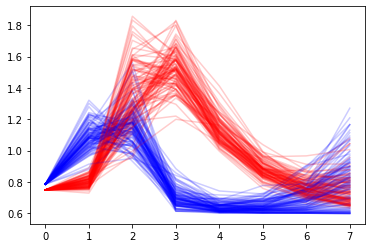

In [5]:
y_plot = y_data.cpu().numpy()
for k in range(100):
    plt.plot(y_plot[k][:,0], 'b', alpha=0.2)
    plt.plot(y_plot[k][:,1], 'r', alpha=0.2)
plt.show()

In [8]:
class VectorField(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, inner_dim=32):
        ######################
        # input_dim is the number of input channels in the data X. (Determined by the data.)
        # hidden_dim is the number of channels for z_t. (Determined by you.)
        ######################
        super(VectorField, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.linear1 = torch.nn.Linear(hidden_dim, inner_dim)
        self.linear2 = torch.nn.Linear(inner_dim, inner_dim)
        self.linear3 = torch.nn.Linear(inner_dim, input_dim * hidden_dim)

    ######################
    # The t argument is not used here; it can be used when you want your CDE to behave differently at different times.
    ######################
    def forward(self, t, z):

        # z has shape (batch, hidden_channels)
        z = self.linear1(z)
        z = z.relu()
        # z = self.linear2(z)
        # z = z.relu()
        z = self.linear3(z)
        z = z.tanh()
        ######################
        # Ignoring the batch dimension, the shape of the output tensor must be a matrix,
        # because we need it to represent a linear map from R^input_channels to R^hidden_channels.
        ######################
        z = z.view(z.size(0), self.hidden_dim, self.input_dim)
        return z

In [9]:
class NeuralCDE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        
        super(NeuralCDE, self).__init__()

        self.func = VectorField(input_dim, hidden_dim)

        self.initial = torch.nn.Linear(input_dim, hidden_dim)
        self.readout = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        # x, t = torchcde.logsignature_windows(x, depth=2, window_length=5)

        coeffs = torchcde.linear_interpolation_coeffs(x)
        # coeffs = linear_interpolation_coeffs(X_input, rectilinear=0)
        X = torchcde.LinearInterpolation(coeffs)

        # coeffs = torchcde.natural_cubic_coeffs(x)
        # X = torchcde.NaturalCubicSpline(coeffs)
        
        X0 = X.evaluate(X.interval[0])
        z0 = self.initial(X0)

        z = torchcde.cdeint(X=X, 
                            func=self.func, 
                            z0=z0, 
                            t=X.grid_points,
                            method='dopri5', 
                            options=dict(grid_points=X.grid_points, eps=1e-5)
                            )

        y = self.readout(z)
        return y

In [45]:
# input_dim=3 because we have a 2-d Brownian motion with time.
# hidden_dim=? is the number of hidden channels for the evolving z_t, which we get to choose.
# output_dim=2 because we have a 2-d response.

model = NeuralCDE(input_dim=3, hidden_dim=8, output_dim=2)
# model = NeuralCDE(input_dim=signatory.logsignature_channels(3,2), hidden_dim=8, output_dim=2)

In [67]:
x_train = x_data[100:250].cuda()
y_train = y_data[100:250].cuda()
x_test = x_data[:100].cuda()
y_test = y_data[:100].cuda()

model = model.cuda()

In [68]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [69]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)

In [70]:
criterion = SigMMD(n=3, solver=2)
# criterion = torch.nn.MSELoss()

In [ ]:
losses = []

In [71]:
num_epochs = 500

for epoch in range(num_epochs):

    for batch in train_dataloader:
        x, y = batch
        pred_y = model(x)
        loss = criterion(pred_y, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    losses.append(loss.item())
    
    if epoch%10==0:
        model.eval()
        with torch.no_grad():
            y_pred = model(x_test)
            test_loss = criterion(y_pred, y_test)
        print('Epoch: {}   Training loss: {}   Test loss: {}'.format(epoch, loss.item(), test_loss.item()))
        model.train()

Epoch: 0   Training loss: 0.5516548156738281   Test loss: 0.42729678750038147
Epoch: 10   Training loss: 0.45628976821899414   Test loss: 0.30860352516174316
Epoch: 20   Training loss: 0.12733177840709686   Test loss: 0.0707063302397728
Epoch: 30   Training loss: 0.046209871768951416   Test loss: 0.020233197137713432
Epoch: 40   Training loss: 0.04370371252298355   Test loss: 0.01777143031358719
Epoch: 50   Training loss: 0.01842660829424858   Test loss: 0.007247659843415022
Epoch: 60   Training loss: 0.013105860911309719   Test loss: 0.00598149886354804
Epoch: 70   Training loss: 0.008341245353221893   Test loss: 0.006119627971202135
Epoch: 80   Training loss: 0.015049945563077927   Test loss: 0.022840041667222977
Epoch: 90   Training loss: 0.006903291214257479   Test loss: 0.005222706124186516
Epoch: 100   Training loss: 0.005211599171161652   Test loss: 0.005201631225645542
Epoch: 110   Training loss: 0.0043052323162555695   Test loss: 0.004866286180913448
Epoch: 120   Training loss

In [72]:
plt.plot(losses)
plt.show()

NameError: ignored

In [73]:
y_pred = model(x_test)

In [74]:
y_pred_ = y_pred.cpu().detach().numpy()
y_test_ = y_test.cpu().detach().numpy()

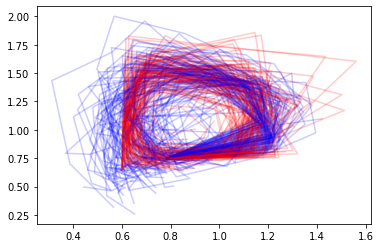

In [75]:
for k in range(100):
    plt.plot(y_pred_[k][:,0], y_pred_[k][:,1], 'b', alpha=0.2, label='generated distribution' if k==0 else '')
    plt.plot(y_test_[k][:,0], y_test_[k][:,1], 'r', alpha=0.2, label='true distribution' if k==0 else '')
plt.legend()
plt.show()

In [78]:
y_pred_ = y_pred.cpu().detach().double()
y_test_ = y_test.cpu().detach().double()

In [79]:
hypothesis_test(y_pred_, y_test_, n=4, solver=1)

Hypothesis accepted: distribution are equal with 99.0% confidence
